In [7]:
import pandas as pd
import numpy as np
import os

# Generate Initial

In [8]:
def generate_initial_data(df, noise_percent=10):
    """
    对每行生成数量等于number_of_jobs的样本，每个样本的收入为median_income加正态噪声
    返回新的DataFrame，每行N个样本，只保留gender和median_income
    """
    income_col = 'median_income'
    jobs_col = 'number_of_jobs'
    records = []
    for _, row in df.iterrows():
        n = int(row[jobs_col])
        mu = row[income_col]
        gender = row['gender']
        incomes = np.random.normal(loc=mu, scale=noise_percent/100 * mu, size=n)
        for income in incomes:
            records.append({'gender': gender, income_col: income})
    return pd.DataFrame(records)

# 用法示例
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)

# print(new_df.head(20))
# print(df.head(20))

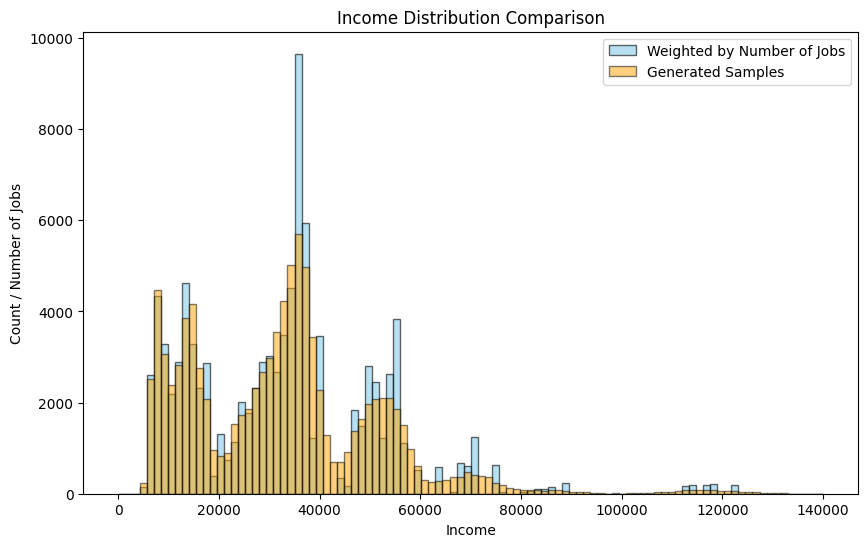

In [15]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 140000, 101)  # 50个等宽bin，范围0~80000
plt.figure(figsize=(10, 6))
plt.hist(df['median_income'], bins=bins, weights=df['number_of_jobs'], color='skyblue', edgecolor='black', alpha=0.6, label='Weighted by Number of Jobs')
plt.hist(new_df['median_income'], bins=bins, color='orange', edgecolor='black', alpha=0.5, label='Generated Samples')
plt.xlabel('Income')
plt.ylabel('Count / Number of Jobs')
plt.title('Income Distribution Comparison')
plt.legend()
plt.show()

# Assign features

In [10]:
def get_feature_stats(df, feature_name, group_col='feature'):
    """
    统计某个特征的概率分布和加权平均收入
    """
    weight_col='number_of_jobs'
    income_col='median_income'
    # 概率分布
    df = df.dropna(subset=[group_col, weight_col, income_col])
    prob = df.groupby(group_col)[weight_col].sum()
    prob = prob / prob.sum()
    # 加权平均收入
    def weighted_mean(x):
        return (x[weight_col] * x[income_col]).sum() / x[weight_col].sum()
    mean_income = df.groupby(group_col).apply(weighted_mean)
    stats = pd.DataFrame({
        'prob': prob,
        'mean_income': mean_income
    })
    return stats

def process_feature_file(folder, fname, show_stats=False):
    """
    处理单个特征文件，返回统计结果
    """
    feature_name = fname[:-11]
    if feature_name in ['Employment size', 'Job duration', 'Type of legal organisation']:
        return None
    fpath = os.path.join(folder, fname)
    df = pd.read_csv(fpath)
    df = df.rename(columns={'feature': feature_name})
    stats = get_feature_stats(df, feature_name=feature_name, group_col=feature_name)
    if show_stats:
        print(f"==== {feature_name} ====")
        print(stats)
        print()
    return stats

In [11]:
# 批量处理文件
folder = r"E:\git\DataScience_Project_Team_25\data\pre_transform"
for fname in os.listdir(folder):
    if fname.endswith('_gender.csv'):
        process_feature_file(folder, fname, show_stats=True)

==== Age group ====
                        prob   mean_income
Age group                                 
14 years and under  0.001448   1137.289386
15 to 17 years      0.022079   2828.853417
18 to 20 years      0.059226   6568.220902
21 to 24 years      0.099093  12854.342791
25 to 29 years      0.133123  21219.066763
30 to 34 years      0.122570  31899.392273
35 to 39 years      0.109689  40428.532942
40 to 44 years      0.094967  45027.931578
45 to 49 years      0.093249  46873.064480
50 to 54 years      0.084626  47077.209990
55 to 59 years      0.075155  45722.038404
60 to 64 years      0.055522  40140.383193
65 to 69 years      0.028512  27427.184164
70 to 74 years      0.012088  15091.587712
75 to 79 years      0.004795   9660.065858
80 to 84 years      0.002230   7137.806440
85 years and over   0.001630   7241.402214

==== Arrival Group ====
                   prob   mean_income
Arrival Group                        
0-5 years      0.185226  29606.286945
11+ years      0.497538 

填充feature主函数

In [22]:
class fill_features:
    def __init__(self, new_df, feature_dist, feature_col, threshold=1000, fill_propotion=0.9, samples_per_round=0.01, test_mode=0):
        self.new_df = new_df
        self.feature_dist = feature_dist
        self.feature_col = feature_col
        self.threshold = threshold
        self.target_num_samples = round(feature_dist['prob'] * new_df.shape[0] * fill_propotion).astype(int)
        self.current_num_samples = pd.Series(0, index=feature_dist.index)
        self.samples_marks = {class_name: [] for class_name in feature_dist.index}
        self.samples_per_round = np.ceil(self.target_num_samples * samples_per_round).astype(int)
        self.rest_samples = new_df.index.tolist()
        self.all_filled = False
        self.diff = {class_name: 0 for class_name in feature_dist.index}
        self.test_mode = test_mode
        self.init_distance_table()

    def init_distance_table(self):
        print("Initializing distance table...")
        self.distance_table = pd.DataFrame(index=self.new_df.index, columns=self.feature_dist.index)
        for class_name in self.feature_dist.index:
            target_mean = self.feature_dist.loc[class_name, 'mean_income']
            self.distance_table[class_name] = (self.new_df['median_income'] - target_mean).abs()
        self.distance_table = self.distance_table.fillna(np.inf)
        print("Distance table initialized.")

    def fill(self):
        round = 0
        while not self.all_filled:
            if self.test_mode == 1 and round >= 2:
                break
            elif self.test_mode == 2 and round >= 20:
                break
            if round % 50 == 0:
                print(f"--- Round {round} ---")
                self.sd_check()
            self.fill_one_round()
            round += 1
            self.filled_finish_check()
        print(f"Filling completed in {round} rounds.")
        print("The final differences:")
        self.sd_check()

    def fill_one_round(self):
        current_to_fill = self.target_num_samples - self.current_num_samples
        for class_name, to_fill in current_to_fill.items():
            if to_fill > 0:
                n_fill = min(self.samples_per_round[class_name], to_fill)
                candidates_idx = self.rest_samples
                candidates_dist = self.distance_table.loc[candidates_idx, class_name]
                select_index = candidates_dist.nsmallest(n_fill).index.tolist()
                
                self.new_df.loc[select_index, self.feature_col] = class_name
                self.current_num_samples[class_name] += n_fill
                self.samples_marks[class_name].extend(select_index)
                self.rest_samples = [idx for idx in self.rest_samples if idx not in select_index]


    def sd_check(self):
        print("Difference from target mean income:")
        for class_name in self.feature_dist.index:
            target_mean = self.feature_dist.loc[class_name, 'mean_income']
            idxs = self.samples_marks[class_name]
            if idxs:
                current_mean = self.new_df.loc[idxs, 'median_income'].mean()
                self.diff[class_name] = target_mean - current_mean
                print(f"  {class_name}: {self.diff[class_name]}")
            else:
                print(f"  {class_name}: No samples assigned")
        print()

    def filled_finish_check(self):
        self.all_filled = all(self.current_num_samples >= self.target_num_samples)

    def get_fill_index(self):
        return self.samples_marks

    def get_result_df(self):
        return self.new_df

In [ ]:
# Test Run feature filling
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
for col in ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']:
    new_df[col] = ""
    
folder = r"E:\git\DataScience_Project_Team_25\data\pre_transform"
feature_dist = process_feature_file(folder, 'Age group_gender.csv')
fill_age = fill_features(new_df, feature_dist, 'Age', threshold=1000, test_mode=0)
fill_age.fill()

Initializing distance table...
Distance table initialized.
--- Round 0 ---
Difference from target mean income:
  14 years and under: No samples assigned
  15 to 17 years: No samples assigned
  18 to 20 years: No samples assigned
  21 to 24 years: No samples assigned
  25 to 29 years: No samples assigned
  30 to 34 years: No samples assigned
  35 to 39 years: No samples assigned
  40 to 44 years: No samples assigned
  45 to 49 years: No samples assigned
  50 to 54 years: No samples assigned
  55 to 59 years: No samples assigned
  60 to 64 years: No samples assigned
  65 to 69 years: No samples assigned
  70 to 74 years: No samples assigned
  75 to 79 years: No samples assigned
  80 to 84 years: No samples assigned
  85 years and over: No samples assigned

--- Round 50 ---
Difference from target mean income:
  14 years and under: -4225.39152457545
  15 to 17 years: -2881.8065911609297
  18 to 20 years: -1.711046535542664
  21 to 24 years: -1.5375115172973892
  25 to 29 years: 4.186869597

In [24]:
# Test with full fill
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
for col in ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']:
    new_df[col] = ""
    
folder = r"E:\git\DataScience_Project_Team_25\data\pre_transform"
feature_dist = process_feature_file(folder, 'Age group_gender.csv')
fill_age = fill_features(new_df, feature_dist, 'Age', threshold=1000, test_mode=0, fill_propotion=1, samples_per_round=0.005)
fill_age.fill()

Initializing distance table...
Distance table initialized.
--- Round 0 ---
Difference from target mean income:
  14 years and under: No samples assigned
  15 to 17 years: No samples assigned
  18 to 20 years: No samples assigned
  21 to 24 years: No samples assigned
  25 to 29 years: No samples assigned
  30 to 34 years: No samples assigned
  35 to 39 years: No samples assigned
  40 to 44 years: No samples assigned
  45 to 49 years: No samples assigned
  50 to 54 years: No samples assigned
  55 to 59 years: No samples assigned
  60 to 64 years: No samples assigned
  65 to 69 years: No samples assigned
  70 to 74 years: No samples assigned
  75 to 79 years: No samples assigned
  80 to 84 years: No samples assigned
  85 years and over: No samples assigned

--- Round 50 ---
Difference from target mean income:
  14 years and under: -4476.37771102568
  15 to 17 years: -2798.395791550153
  18 to 20 years: -4.454566879285267
  21 to 24 years: -31.704560779498934
  25 to 29 years: -282.2407611

In [ ]:
# 批量处理feature filling
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
feature_names = ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']
for col in feature_names:
    new_df[col] = ""

feature_files = [
    'Age group_gender.csv',
    'Arrival Group_gender.csv',
    'Business size_gender.csv',
    'Industry_gender.csv',
    'Institutional sector_gender.csv',
    'Job duration from T20_gender.csv',
    'Visa group_gender.csv'
]

for feature_name, fname in zip(feature_names, feature_files):
    feature_dist = process_feature_file(folder, fname)
    print("Assigning feature:", feature_name)
    fill_feature = fill_features(new_df, feature_dist, feature_name, threshold=1000, test_mode=0, fill_propotion=1, samples_per_round=0.005)
    fill_feature.fill() #update new_df


check filling feature: Age
check using file: Age group_gender.csv
check filling feature: Arrival_group
check using file: Arrival Group_gender.csv
check filling feature: Business_size
check using file: Business size_gender.csv
check filling feature: Industry
check using file: Industry_gender.csv
check filling feature: Institutional_sector
check using file: Institutional sector_gender.csv
check filling feature: Job_duration
check using file: Job duration from T20_gender.csv
check filling feature: Visa_group
check using file: Visa group_gender.csv
